# Convert Your Documents to Stylized HTML using the Unstructured API

Do you have unstructured data scattered across PDFs, PowerPoints, scanned documents, and images and wish you could display them in a consistent visual format?

Maybe you're building a chatbot and want to render source snippets directly in your web app. Or perhaps you need to convert entire documents into browsable HTML for a knowledge base. Whatever the use case, having a reliable way to turn diverse document types into clean HTML makes your application code simpler and your user experience far more consistent.

That's where **Unstructured** comes in.

Unstructured is an ETL platform that transforms complex, unstructured documents into clean, structured data — perfect for RAG pipelines, agentic AI, and GenAI applications. When you parse a document with Unstructured, you get back a list of **document elements** (titles, paragraphs, tables, images, etc.), each with rich metadata that includes an HTML representation of the content.


### Why Convert to HTML?

If you try using a vanilla VLM to convert your documents, you'll quickly run into consistency issues — different models produce different output structures, and setting up a production pipeline involves a lot of orchestration headaches.

By converting all your documents to HTML first through Unstructured:
- Your application code stays **clean and minimal**
- The UX experience is **consistent** across all source document types
- You get a **standardized output** that's easy to style and render


### What You'll Learn

In this notebook, we'll use the Unstructured API to:

1. **Parse a PDF** using the VLM strategy — converting it into a structured JSON representation (perfect for RAG pipelines)
2. **Extract the HTML** that lives within each element's metadata
3. **Reconstitute the HTML** into a single, complete document
4. **Apply CSS styling** to create a polished, production-ready result

We've included two pre-built themes — **dark** and **light** — but you'll likely want to customize these to match your company's branding.

By the end, you'll have everything you need to convert PDFs, PowerPoints, and scanned documents into beautifully styled HTML.


### A Note on Partitioning Strategies

Unstructured offers four partitioning strategies, each optimized for different use cases:

| Strategy | Best For |
|----------|----------|
| **Auto** | Most cases — intelligently routes to the best strategy per page |
| **VLM** | Highest-quality transformation of PDFs, images, and presentations |
| **High Res** | Other file types, or when bounding box coordinates are needed |
| **Fast** | Text-only documents where speed matters most |

**Important:** Only the **VLM strategy** generates a full HTML representation of your document. The other strategies are also great for RAG and text extraction, but if you want HTML output, VLM is the way to go.

For this notebook, we'll be using **Vertex AI's Gemini 2.5 Flash** as our VLM provider.


Let's get started!

## Prerequisites

Before we begin, make sure you have the following:

### 1. Unstructured API Key

You'll need an API key to access the Unstructured platform.

- **Sign up for free** at [Unstructured](https://unstructured.io/?modal=try-for-free) — you get 15,000 pages with no time limit and full access to all features.
- Once logged in, go to **API Keys** in the sidebar ([direct link](https://platform.unstructured.io/api-keys)) and generate a new key.
- Add your key to Google Colab's **Secrets** (🔑 icon in the left sidebar) with the name `UNSTRUCTURED_API_KEY`.

### 2. Sample Document

For this tutorial, we'll use a research paper from arXiv:

> **Wang, Z., Liu, X., & Zhang, M. (2022).** *Breaking the Representation Bottleneck of Chinese Characters: Neural Machine Translation with Stroke Sequence Modeling.* [arXiv:2211.12781](https://arxiv.org/pdf/2211.12781)

We'll download this automatically.

**Using your own document?** The VLM strategy supports: `.pdf`, `.ppt`, `.pptx`, `.jpg`, `.jpeg`, `.png`, `.gif`, `.webp`, `.bmp`, `.tiff`, and `.heic`.



Let's first start by installing the libraries we'll need:

In [ ]:
!pip install unstructured-client

## Step 1: Parse Your Documents using the VLM strategy of the Unstructured API

Now we'll use Unstructured's **On-Demand API** to parse our PDF. Parsing (also called partitioning) is the process of extracting structured content from raw documents — Unstructured breaks down your file into semantic **document elements** (titles, paragraphs, tables, images, etc.) and returns them as JSON.


> 📝 **Note:** In this tutorial, we're processing a single file for demonstration purposes. If you need to process documents at scale, check out Unstructured's [Workflows Operations](https://docs.unstructured.io/api-reference/workflow/overview) which supports batch processing with source and destination connectors.

Let's start by initializing the Unstructured client.

In [2]:
from unstructured_client import UnstructuredClient
from unstructured_client.models.operations import CreateJobRequest
from unstructured_client.models.shared import BodyCreateJob, InputFiles
from google.colab import files as google_colab_files
from google.colab import userdata
import os, json


First, we'll load our API key from Colab Secrets and initialize the Unstructured client:

In [3]:
os.environ["UNSTRUCTURED_API_KEY"] = userdata.get("UNSTRUCTURED_API_KEY")
client = UnstructuredClient(api_key_auth=os.environ["UNSTRUCTURED_API_KEY"])

Next, let's set up our input and output directories and download the sample PDF from arXiv:

In [ ]:
# Fetch the input pdf from public and store it.
os.makedirs("/content/input", exist_ok=True)
os.makedirs("/content/output", exist_ok=True)


!wget -O /content/input/Sample-Input.pdf "https://arxiv.org/pdf/2211.12781"

In [5]:
INPUT_PATH = "/content/input"
OUTPUT_PATH = "/content/output"
input_file_path = "/content/input/Sample-Input.pdf"
VLM_ELIGIBLE_FILE_TYPES = ["pdf", "ppt", "pptx", "jpg", "jpeg", "png", "tiff", "heic", "webp"] # is this needed to be shown?

Now we'll define a helper function to run an **on-demand job** with Unstructured. This function:

1. Takes an input file and packages it for the API
2. Configures the job with our specified workflow nodes (in this case, the VLM partitioner)
3. Submits the job and returns the job ID and file information

We'll configure the VLM partitioner to use **Vertex AI's Gemini 2.0 Flash** model. You can swap this out for other supported providers like OpenAI, Anthropic, or AWS Bedrock — see the [full list of supported models](https://docs.unstructured.io/api-reference/workflow/workflows#partitioner-node).


Let's define the function and kick off the job:

In [6]:

def run_on_demand_job(client, input_file_path, template_id=None, job_nodes=None):
    request_data = {}
    files = []


    files.append(
        (
            InputFiles(
                content=open(input_file_path, "rb"),
                file_name=input_file_path.split("/")[-1],
                content_type="application/pdf"
            )
        )
    )

    if template_id is not None:
        request_data = json.dumps({"template_id": template_id})
    elif job_nodes is not None:
        request_data = json.dumps({"job_nodes": job_nodes})
    else:
        raise ValueError(f"Must provide a workflow template ID or a custom workflow definition for this job (but not both).")

    # Run the on-demand job, capturing the job ID and the job's
    # input/output file IDs and output node IDs.
    response = client.jobs.create_job(
        request=CreateJobRequest(
            body_create_job=BodyCreateJob(
                request_data=request_data,
                input_files=files
            )
        )
    )

    job_id = response.job_information.id
    job_input_file_ids = response.job_information.input_file_ids
    job_output_node_files = response.job_information.output_node_files

    return job_id, job_input_file_ids, job_output_node_files

vlm_partitioner_node = {
    "name": "Partitioner",
    "subtype": "vlm",
    "type": "partition",
    "settings": {
        "provider": "vertexai",
        "model": "gemini-2.0-flash-001",
        "is_dynamic": False,
        "allow_fast": True
    }
}
job_nodes = [ vlm_partitioner_node ]

job_id = ""
job_input_file_ids = []
job_output_node_files = []

job_id, job_input_file_ids, job_output_node_files = run_on_demand_job(
    client = client,
    input_file_path = input_file_path,
    job_nodes = job_nodes
)

print(f"Job ID: {job_id}\n")
print("Input file details:\n")

for job_input_file_id in job_input_file_ids:
    print(job_input_file_id)

print("\nOutput node file details:\n")

for output_node_file in job_output_node_files:
    print(output_node_file)



Job ID: 656e1bab-f310-4728-acb4-658d20a78a83

Input file details:

Sample-Input-f4e2e0d4.pdf

Output node file details:

file_id='Sample-Input-f4e2e0d4.pdf' node_id='31cdeb03-55af-40ed-8aa6-fe87dae233c2' node_subtype='vlm' node_type='partition'


These jobs run asynchronously, so we need to poll for the job status until it completes. The following function checks every 10 seconds and returns once the job is done:

In [ ]:
import time
from unstructured_client import UnstructuredClient

def poll_job_status(client, job_id):
    while True:
        response = client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print("Job is scheduled, polling again in 10 seconds...")
            time.sleep(10)
        elif job.status == "IN_PROGRESS":
            print("Job is in progress, polling again in 10 seconds...")
            time.sleep(10)
        else:
            print("Job is completed.")
            break

    return job


job = poll_job_status(client, job_id)
print(f"Job details:\n---\n{job.model_dump_json(indent=4)}")

Let's verify that our file was processed successfully by checking for any failures:

In [8]:
from unstructured_client.models.operations import GetJobFailedFilesRequest

def get_failed_files_details(client, job_id):
    response = client.jobs.get_job_failed_files(
        request=GetJobFailedFilesRequest(
            job_id=job_id
        )
    )

    info = response.job_failed_files

    if info.failed_files.__len__() > 0:
        print(f"{info.failed_files.__len__()} failed file(s):")

        for failed_file in info.failed_files:
            print(f"---")
            print(f"document: {failed_file.document}")
            print(f"error:    {failed_file.error}")
    else:
        print(f"No failed files.")

get_failed_files_details(client, job_id)

No failed files.


Now we can download the processed output. The result is a JSON file containing all the document elements — each with its extracted text, type, and metadata (including the `text_as_html` field we'll use to build our HTML):

In [9]:
from unstructured_client.models.operations import DownloadJobOutputRequest

def download_job_output(client, job_id, job_input_file_ids, output_dir):
    for job_input_file_id in job_input_file_ids:
        print(f"Attempting to get processed results from file_id '{job_input_file_id}'...")

        response = client.jobs.download_job_output(
            request=DownloadJobOutputRequest(
                job_id=job_id,
                file_id=job_input_file_id
            )
        )

        output_path = os.path.join(output_dir, f"{input_file_path.split("/")[-1]}.json")

        with open(output_path, "w") as f:
            json.dump(response.any, f, indent=4)

        print(f"Saved output for file_id '{job_input_file_id}' to '{output_path}'.\n")
        return output_path


output_file_path = download_job_output(client, job_id, job_input_file_ids, OUTPUT_PATH)

Attempting to get processed results from file_id 'Sample-Input-f4e2e0d4.pdf'...
Saved output for file_id 'Sample-Input-f4e2e0d4.pdf' to '/content/output/Sample-Input.pdf.json'.



In [10]:
def read_json(file_path):
  with open(file_path, 'r') as f:
    file_as_json = json.load(f)

  return file_as_json

file_as_json = read_json(output_file_path)

# The `file_as_json` is a JSON representation of the document's contents, and each element
# has a `metadata` field that contains the HTML representation of the element: `metadata.text_as_html`
# Print the first element of the JSON array to verify that the HTML field is present.
print(file_as_json[2])
print(file_as_json[2]['metadata']['text_as_html'])

{'type': 'Title', 'element_id': '76fae095484a441d8935bd336a8d14e3', 'text': 'Breaking the Representation Bottleneck of Chinese Characters:Neural Machine Translation with Stroke Sequence Modeling', 'metadata': {'category_depth': 2, 'page_number': 1, 'parent_id': '23f5067afe984774bf94b816b8dc4a6d', 'text_as_html': '<h1 class="Title">Breaking the Representation Bottleneck of Chinese Characters:Neural Machine Translation with Stroke Sequence Modeling</h1>', 'languages': ['eng'], 'filetype': 'application/pdf', 'partitioner_type': 'vlm_partition', 'data_source': {'url': 'file:///home/etl/node/downloads/00000000-0000-0000-0000-000000000001/b9acbbf8-Sample-Input-f4e2e0d4.pdf', 'record_locator': {'protocol': 'file', 'remote_file_path': 'file:///home/etl/node/downloads/00000000-0000-0000-0000-000000000001/b9acbbf8-Sample-Input-f4e2e0d4.pdf'}}, 'filename': 'Sample-Input-f4e2e0d4.pdf'}}
<h1 class="Title">Breaking the Representation Bottleneck of Chinese Characters:Neural Machine Translation with S


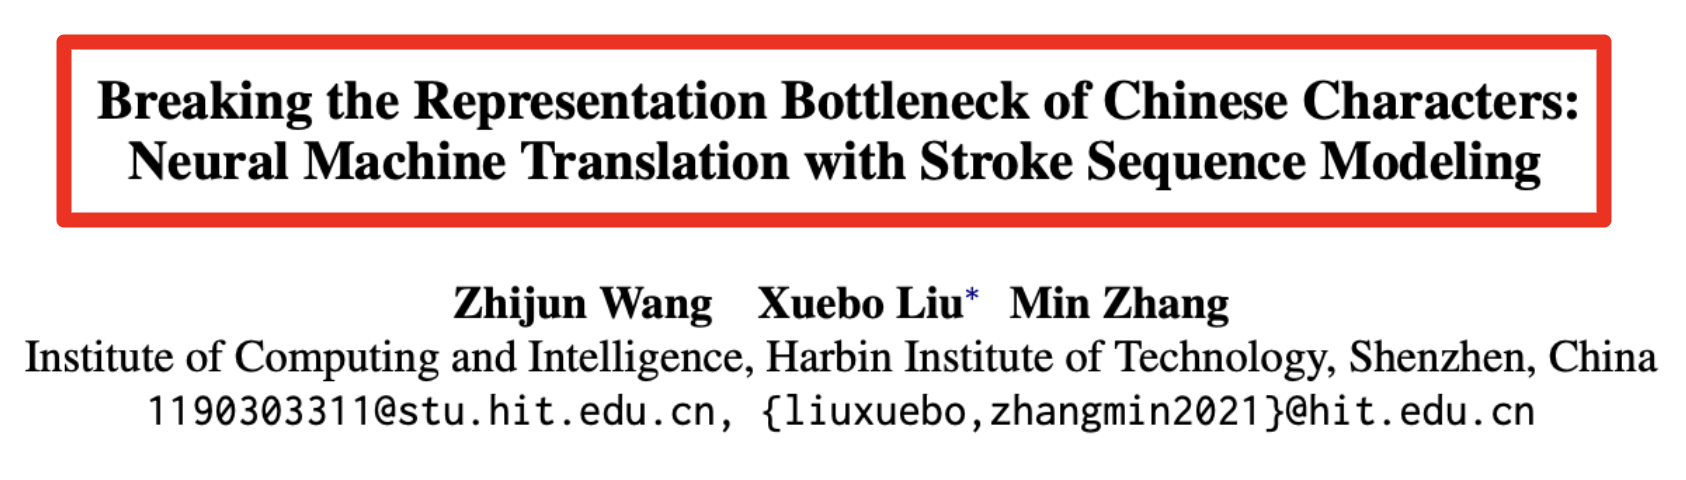

We've successfully processed our PDF with Unstructured's VLM strategy.

As you can see, each document element contains:
- **`type`** — the semantic category (e.g., `Title`, `NarrativeText`, `Table`)
- **`element_id`** — a unique identifier for the element
- **`text`** — the extracted text content
- **`metadata`** — additional information, including the crucial `text_as_html` field

The `text_as_html` field contains a high-fidelity HTML representation of each element, and this is exactly what we'll use to reconstruct the full document.

To learn more about document elements and their metadata, check out the [docs](https://docs.unstructured.io/ui/document-elements) here.


Now that we have our structured JSON with HTML embedded in the metadata, let's extract and combine it into a single, complete HTML document.

## Step 2: Convert the JSON representation of the file into an HTML representation

Now that we have our parsed document as JSON, we need to extract the HTML from each element's metadata and combine it into a single, well-structured HTML document.

The `VlmJsonToHtmlConverter` class below handles this conversion. Here's what it does at a high level:

1. **Builds a document tree** — Uses the `parent_id` field in each element's metadata to reconstruct the hierarchical structure of the original document (pages, sections, columns, etc.)

2. **Extracts HTML content** — Pulls the `text_as_html` field from each element's metadata, which contains the VLM-generated HTML representation

3. **Handles container elements** — Properly nests content within structural elements like `Page`, `Section`, and `Header`

4. **Assembles the final document** — Wraps everything in a complete HTML document with proper `<!DOCTYPE>`, `<head>`, and `<body>` tags

The result is a clean, semantic HTML file that preserves the structure and formatting of your original document.

In [11]:
from typing import Dict, List, Optional
from collections import defaultdict

class VlmJsonToHtmlConverter:
    """Converts VLM JSON data to structured HTML with proper nesting."""

    # Container elements that should wrap their children
    CONTAINER_TAGS = {
        'Page': 'div',
        'Section': 'section',
        'Column': 'div',
        'Header': 'header',
        'Footer': 'footer',
        'Form': 'form',
    }

    def __init__(self, title: Optional[str] = None):
        self.title = title
        self.document_title = "Converted Document"
        self._theme_css = ""  # For CSS styling
        self._elements_by_id: Dict[str, Dict] = {}
        self._children_by_parent: Dict[str, List[str]] = defaultdict(list)
        self._root_elements: List[str] = []

    def convert(self, json_data: List[Dict]) -> str:
        """Convert JSON data to HTML document."""
        if not json_data:
            raise ValueError("JSON data cannot be empty")

        self._build_tree(json_data)
        return self._build_document()

    def _build_tree(self, data: List[Dict]) -> None:
        """Build parent-child relationships from flat JSON."""
        for element in data:
            if 'metadata' not in element:
                continue

            element_id = element.get('element_id')
            if not element_id:
                continue

            metadata = element['metadata']

            # Extract document title
            if self.title is None and 'filename' in metadata:
                self.document_title = metadata['filename']
                self.title = self.document_title

            self._elements_by_id[element_id] = element

            parent_id = metadata.get('parent_id')
            if parent_id:
                self._children_by_parent[parent_id].append(element_id)
            else:
                self._root_elements.append(element_id)

    def _render_element(self, element_id: str) -> str:
        """Recursively render an element and its children."""
        element = self._elements_by_id.get(element_id)
        if not element:
            return ""

        metadata = element.get('metadata', {})
        text_as_html = metadata.get('text_as_html', '')
        element_type = element.get('type', '')
        text = element.get('text', '')

        # Render children first
        children_ids = self._children_by_parent.get(element_id, [])
        children_html = '\n'.join(
            self._render_element(child_id)
            for child_id in children_ids
        )

        # Check if this is a container element (Page, Section, etc.)
        if self._is_container(text_as_html):
            return self._render_container(text_as_html, children_html, metadata)

        # For leaf elements, return the HTML content
        if text_as_html and not self._is_self_closing(text_as_html):
            return text_as_html

        # Fallback: create element from type and text
        if text:
            tag = self._get_tag_for_type(element_type)
            return f'<{tag} class="{element_type}">{text}</{tag}>'

        return ""

    def _is_container(self, html: str) -> bool:
        """Check if element is a container that should wrap children."""
        for container_type in self.CONTAINER_TAGS:
            if f'class="{container_type}"' in html:
                return True
        return False

    def _is_self_closing(self, html: str) -> bool:
        """Check if HTML is self-closing (invalid for non-void elements)."""
        # Only flag as self-closing if it's NOT a void element
        void_elements = ['img', 'br', 'hr', 'input', 'meta', 'link']
        if '/>' not in html:
            return False
        return not any(f'<{void}' in html.lower() for void in void_elements)

    def _render_container(self, html: str, children_html: str, metadata: Dict) -> str:
        """Render a container element with proper opening/closing tags."""
        # Determine container class from HTML
        container_class = None
        for cls in self.CONTAINER_TAGS:
            if f'class="{cls}"' in html:
                container_class = cls
                break

        if not container_class:
            container_class = 'div'

        tag = self.CONTAINER_TAGS.get(container_class, 'div')

        # Build attributes
        attrs = f'class="{container_class}"'
        if container_class == 'Page':
            page_num = metadata.get('page_number', 1)
            attrs += f' data-page-number="{page_num}"'

        return f'<{tag} {attrs}>\n{children_html}\n</{tag}>'

    def _get_tag_for_type(self, element_type: str) -> str:
        """Map element types to HTML tags."""
        type_to_tag = {
            'Title': 'h1',
            'Subtitle': 'h2',
            'Heading': 'h3',
            'NarrativeText': 'p',
            'Paragraph': 'p',
            'ListItem': 'li',
            'Table': 'table',
            'Image': 'img',
            'FigureCaption': 'figcaption',
            'Caption': 'figcaption',
            'Footnote': 'div',
            'UncategorizedText': 'div',
        }
        return type_to_tag.get(element_type, 'div')

    def _build_document(self) -> str:
        """Build complete HTML document."""
        body_parts = []
        for element_id in self._root_elements:
            rendered = self._render_element(element_id)
            if rendered:
                body_parts.append(rendered)

        body_content = '\n'.join(body_parts)

        # Add CSS section if theme is set
        css_section = f"<style>\n{self._theme_css}\n</style>" if self._theme_css else ""

        return f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>{self.document_title}</title>
    {css_section}
</head>
<body class="Document">
{body_content}
</body>
</html>"""

Let's run the converter and save the output to an HTML file:

> 💡 **Tip:** Want to download the file? Uncomment the last line to automatically download the HTML to your local machine.

In [12]:
file_as_html = VlmJsonToHtmlConverter().convert(file_as_json)
print(file_as_html)

# You can also save the file and open it in a browser to see!
html_file_name = f"{OUTPUT_PATH}/Sample-Input.pdf.json-normal.html"
with open(html_file_name, "w") as file:
    file.write(file_as_html)

# google_colab_files.download(html_file_name)

<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Sample-Input-f4e2e0d4.pdf</title>
    
</head>
<body class="Document">
<div class="Page" data-page-number="1">
<section class="Section">
<h1 class="Title">Breaking the Representation Bottleneck of Chinese Characters:Neural Machine Translation with Stroke Sequence Modeling</h1>
<p class="Paragraph">Zhijun Wang Xuebo Liu* Min Zhang</p><p class="Paragraph">Institute of Computing and Intelligence, Harbin Institute of Technology, Shenzhen, China</p><p class="Paragraph">1190303311@stu.hit.edu.cn, {liuxuebo,zhangmin2021}@hit.edu.cn</p>
</section>
<section class="Section">
<p class="Paragraph">Abstract</p><p class="NarrativeText">Existing research generally treats Chinesecharacter as a minimum unit for representa-tion. However, such Chinese character rep-resentation will suffer two bottlenecks: 1)Learning bottleneck, the learning cannot ben-efit from its rich internal features (e.g., rad-icals and strokes); and 2) Parameter bo

## Step 3: Stylize the Outputs

Now that we have our HTML, the document can be visualized. However, if you did save the html to a file and open it in a browser, you will notice it is very basic.

If you want to actually display the HTML contents in a production application, you may wish to present it with some basic styling. This is done by adding CSS formatting to it. Because Unstructured's HTML leverages a standardized ontology, you can use that to create visually appealing CSS styling!


We've provided a dark theme and light theme as a starting point, but feel free to modify or customize however you see fit for your company's brand or use case.


In [13]:
#@markdown 🎨 CSS Styling Definitions

LIGHT_MODE_CSS_STYLING = """
    :root {
        --bg-primary: #f5f5f5;
        --bg-secondary: rgba(235, 254, 225, 0.078);
        --bg-tertiary: rgba(240, 234, 230, 0.65);
        --bg-teal: #2b8b9c;
        --bg-darker-teal: #04cbef;
        --bg-dark-sky-blue: #74b0ec;
        --bg-light-sky-blue: #bbe5fa;
        --bg-cloud-light-white: #f8f5f7;
        --bg-cloud-light-pink: #f0e8e8e6;
        --bg-cloud-light-yellow: #fcf8ee;
        --bg-dark: rgba(9, 26, 29, 0.788);
        --bg-darker: rgba(11, 34, 39, 0.862);


        /* Gradient overlays */
        --overlay-blue: rgba(104, 187, 243, 0.03);
        --overlay-teal: rgba(101, 218, 244, 0.04);

        /* Text colors */
        --text-primary: #030e10;
        --text-secondary: #162232;
        --text-muted: rgba(225, 243, 254, 0.6);
        --text-light: #f5f5f5;
        --text-blue: #148edf;
        --text-dark-blue: #056baf;
        --text-teal: #04caf6;
        --text-dark-teal: #0289a7;
        /* Accent colors */
        --accent-blue: #68bbf3;
        --accent-teal: #65daf4;
        --accent-lime: #8bfaad;
        --accent-yellow: rgba(253, 246, 128, 0.85);
        --accent-pink: rgba(232, 167, 225, 0.75);
        --accent-red: rgba(236, 98, 92, 0.9);

        /* Warm accent palette */
        --accent-peach: rgba(232, 192, 170, 0.85);
        --accent-peach-dark: rgba(146, 96, 69, 0.85);
        --accent-pink-red: rgba(192, 160, 158, 0.8);
        --accent-soft-peach: rgba(236, 225, 218, 0.282);

        /* Subtle colors */
        --border-light: rgba(225, 243, 254, 0.08);
        --border-medium: rgba(225, 243, 254, 0.12);

        /* Warm gradients */
        --gradient-warm: linear-gradient(105deg,
                rgba(232, 192, 170, 0.05),
                rgba(236, 98, 92, 0.05));
    }

    body.Document {
        background-color: var(--bg-primary);
        color: var(--text-primary);
        font-family: Arial, sans-serif;
        line-height: 1.6;
        min-height: 100vh;
    }

    .Section,
    .Page,
    .Column {
        margin-bottom: 20px;
    }

    .Page {
        margin-bottom: 40px;
        padding: 30px;
        background-color: radial-gradient(var(--accent-yellow),
                var(--accent-pink));
        border-radius: 12px;
        box-shadow: 0 8px 32px rgba(0, 0, 0, 0.12);
        position: relative;
        border: 2px solid var(--bg-darker-teal);
        backdrop-filter: blur(20px);
    }

    .Page::after {
        content: attr(data-page-number);
        position: absolute;
        bottom: 15px;
        right: 15px;
        font-size: 0.8em;
        color: var(--accent-teal);
        background: linear-gradient(115deg, var(--bg-secondary), var(--bg-tertiary));
        padding: 4px 12px;
        border-radius: 6px;
        border: 1px solid var(--border-light);
    }

    .Page:not(:last-child)::before {
        content: '';
        display: block;
        height: 1px;
        background-color: var(--border-medium);
        margin: 15px 0;
    }

    .Section {
        background: linear-gradient(100deg,
                var(--bg-cloud-light-white),
                var(--bg-cloud-light-yellow),
                var(--bg-cloud-light-pink));
        border-radius: 12px;
        padding: 10px;
        margin-bottom: 30px;
        border: 2px solid var(--text-dark-teal);
        display: flex;
        flex-wrap: wrap;
        flex-direction: column;
        justify-content: space-between;
        filter: drop-shadow(0 0 0.75rem rgba(243, 212, 218, 0.189));
    }

    .Column {
        flex: 1;
        min-width: 0;
        padding: 0 10px;
    }

    .Section.two-column .Column {
        flex-basis: calc(50% - 20px);
    }

    .Section.three-column .Column {
        flex-basis: calc(33.333% - 20px);
    }

    .Section.four-column .Column {
        flex-basis: calc(25% - 20px);
    }

    .Section.five-column .Column {
        flex-basis: calc(20% - 20px);
    }
    .Section .Title {
        width:  100%;
    }

    .Header,
    .Footer,
    .Sidebar {
        padding: 10px;
        border-radius: 5px;
        background-color: linear-gradient(100deg,
                var(--accent-pink),
                var(--accent-yellow));
    }

    .PageBreak {
        border: none;
        border-top: 1px dashed var(--border-medium);
        margin: 20px 0;
    }

    .Title {
        color: var(--text-blue);
        margin-bottom: 20px;
        font-size: 2em;
        letter-spacing: -0.02em;
        border-radius: 10px;
        /* width: 100%; */
    }

    .Subtitle {
        color: var(--accent-red);
        margin-bottom: 15px;
        font-size: 1.2em;
        letter-spacing: 0.01em;
    }

    .Heading {
        color: var(--accent-blue);
        margin-bottom: 15px;
    }

    .NarrativeText,
    .UncategorizedText {
        margin-bottom: 10px;
    }

    .Quote {
        border-left: 3px solid var(--accent-lime);
        padding: 20px;
        margin: 20px 0;
        background: linear-gradient(90deg,
                rgba(139, 250, 173, 0.08),
                rgba(232, 192, 170, 0.03));
        border-radius: 0 8px 8px 0;
    }

    .Footnote,
    .Caption,
    .PageNumber {
        font-size: 0.9em;
        color: var(--text-muted);
    }

    .OrderedList,
    .UnorderedList,
    .DefinitionList {
        margin-left: 20px;
        margin-bottom: 15px;
    }

    .ListItem {
        margin-bottom: 5px;
        list-style-type: circle;
    }

    .Table {
        border-collapse: separate;
        border-spacing: 0;
        width: 100%;
        border-radius: 8px;
        overflow: hidden;
        border: 1px solid var(--accent-blue);
        margin-bottom: 15px;
    }

    .TableRow,
    .TableCell {
        border: 1px solid var(--accent-blue);
        padding: 12px 16px;
    }

    .TableHeader {
        background: linear-gradient(90deg, var(--bg-dark-sky-blue), var(--bg-light-sky-blue));
        color: var(--text-dark);
        font-weight: 500;
        padding: 12px 16px;
    }

    .Image,
    .Figure,
    .Video,
    .Audio,
    .Barcode,
    .QRCode,
    .Logo {
        height: auto;
        margin-bottom: 5px;
        font-style: italic;
    }

    .CodeBlock,
    .InlineCode {
        font-family: 'Fira Code', monospace;
        background: var(--bg-tertiary);
        padding: 20px;
        border-radius: 8px;
        border: 1px solid var(--border-medium);
        color: var(--accent-lime);
        margin: 20px 0;
    }

    .Formula,
    .Equation {
        font-style: italic;
        margin: 10px 0;
    }

    .FootnoteReference,
    .Citation,
    .Bibliography,
    .Glossary {
        color: var(--accent-teal);
    }

    .Author,
    .Date,
    .Keywords {
        color: var(--text-secondary);
        font-size: 0.9em;
    }

    .TableOfContents,
    .Index {
        background: var(--bg-tertiary);
        padding: 20px;
        border-radius: 8px;
        margin-bottom: 15px;
        border: 1px solid var(--border-medium);
    }

    .Form {
        margin-bottom: 15px;
        padding: 10px;
        border-radius: 20px;
        border: 1px solid var(--bg-dark-sky-blue);
        background: linear-gradient(180deg,
                var(--bg-cloud-light-white),
                var(--text-muted))
    }

    .FormField {
        border: 1px solid var(--accent-red);
        padding: 12px;
        border-radius: 6px;
        font-weight: 800;
        color: var(--text-primary);
        transition: all 0.2s ease;
        display: block;
        margin-bottom: 10px;
        background: linear-gradient(165deg,
                var(--bg-cloud-light-white),
                var(--bg-cloud-light-pink));
    }

    .FormFieldValue {
        padding: 0px 8px 0px 8px;
        border-radius: 9px;
        background-color: var(--accent-soft-peach);
        color: var(--text-dark);
        border: 1px solid var(--accent-peach-dark);
    }

    .Button {
        background: linear-gradient(135deg, var(--accent-blue), var(--accent-teal));
        color: var(--bg-primary);
        border: none;
        padding: 10px 20px;
        border-radius: 6px;
        cursor: pointer;
        font-weight: 500;
        transition: all 0.3s ease;
        box-shadow: 0 2px 8px rgba(104, 187, 243, 0.2);
    }

    .Button:hover {
        transform: translateY(-1px);
        box-shadow: 0 4px 12px rgba(104, 187, 243, 0.3);
    }

    .Button.critical {
        background: linear-gradient(135deg,
                var(--accent-red),
                var(--accent-pink-red));
    }

    .Comment {
        color: var(--accent-lime);
        font-style: italic;
    }

    .Highlight {
        background: linear-gradient(120deg,
                rgba(253, 246, 128, 0.1),
                rgba(232, 167, 225, 0.1));
        padding: 2px 6px;
        border-radius: 4px;
    }

    .RevisionInsertion {
        color: var(--accent-lime);
        text-decoration: none;
        border-bottom: 1px dashed rgba(139, 250, 173, 0.4);
    }

    .RevisionDeletion {
        color: var(--accent-red);
        text-decoration: line-through;
        border-bottom: 1px dashed rgba(236, 98, 92, 0.4);
    }

    .Address,
    .EmailAddress,
    .PhoneNumber,
    .Date,
    .Time,
    .Currency,
    .Measurement {
        color: var(--accent-peach-dark);
    }

    .Date.important {
        color: var(--accent-pink-red);
        font-weight: 500;
    }

    .Letterhead,
    .Signature,
    .Watermark,
    .Stamp {
        opacity: 0.7;
    }

    .Hyperlink {
        color: var(--accent-teal);
        text-decoration: none;
        transition: all 0.2s ease;
        border-bottom: 1px solid rgba(101, 218, 244, 0.2);
    }

    .Hyperlink:hover {
        border-bottom-color: var(--accent-teal);
    }

    .Hyperlink.featured {
        background: linear-gradient(90deg,
                var(--accent-peach),
                var(--accent-pink));
        -webkit-text-fill-color: transparent;
        border-bottom: none;
    }

    .Alert {
        background: linear-gradient(135deg,
                rgba(236, 98, 92, 0.08),
                rgba(232, 167, 225, 0.05));
        border-left: 3px solid var(--accent-red);
        padding: 16px 20px;
        border-radius: 0 8px 8px 0;
        margin: 20px 0;
    }

    .Priority {
        display: inline-block;
        padding: 2px 8px;
        border-radius: 4px;
        font-size: 0.85em;
        font-weight: 500;
    }

    .Priority.high {
        background: rgba(236, 98, 92, 0.1);
        color: var(--accent-red);
        border: 1px solid rgba(236, 98, 92, 0.2);
    }

    .Priority.medium {
        background: rgba(232, 167, 225, 0.1);
        color: var(--accent-pink);
        border: 1px solid rgba(232, 167, 225, 0.2);
    }

    .Tag {
        display: inline-block;
        padding: 3px 10px;
        border-radius: 12px;
        font-size: 0.85em;
        margin: 0 4px;
        background: var(--bg-tertiary);
    }

    .Tag.featured {
        background: rgba(232, 192, 170, 0.1);
        color: var(--accent-peach);
        border: 1px solid rgba(232, 192, 170, 0.15);
    }

    .Progress {
        height: 4px;
        background: var(--bg-tertiary);
        border-radius: 2px;
        overflow: hidden;
    }

    .Progress .bar {
        height: 100%;
        background: linear-gradient(90deg,
                var(--accent-blue),
                var(--accent-pink));
        transition: width 0.3s ease;
    }

    .Decorator {
        position: absolute;
        width: 100px;
        height: 100px;
        opacity: 0.03;
        filter: blur(40px);
        border-radius: 50%;
        pointer-events: none;
    }

    ::selection {
        background: rgba(232, 167, 225, 0.2);
        color: var(--text-primary);
    }
"""
DARK_MODE_CSS_STYLING = """
    :root {
      --bg-primary: #030e10;
      --bg-secondary: #0a1f24;
      --bg-tertiary: #162232;

      /* Gradient overlays */
      --overlay-blue: rgba(104, 187, 243, 0.03);
      --overlay-teal: rgba(101, 218, 244, 0.04);

      /* Text colors */
      --text-primary: #f5f5f5;
      --text-secondary: rgba(225, 243, 254, 0.85);
      --text-muted: rgba(225, 243, 254, 0.6);
      --text-dark: #030e10;

      /* Accent colors */
      --accent-blue: #68bbf3;
      --accent-teal: #65daf4;
      --accent-lime: #8bfaad;
      --accent-yellow: rgba(253, 246, 128, 0.85);
      --accent-pink: rgba(232, 167, 225, 0.75);
      --accent-red: rgba(236, 98, 92, 0.9);

      /* Warm accent palette */
      --accent-peach: rgba(232, 192, 170, 0.85);
      --accent-pink-red: rgba(192, 160, 158, 0.8);

      /* Subtle colors */
      --border-light: rgba(225, 243, 254, 0.08);
      --border-medium: rgba(225, 243, 254, 0.12);

      /* Warm gradients */
      --gradient-warm: linear-gradient(
        135deg,
        rgba(232, 192, 170, 0.05),
        rgba(236, 98, 92, 0.05)
      );
    }

    body.Document {
      background-color: var(--bg-primary);
      color: var(--text-primary);
      font-family: Arial, sans-serif;
      line-height: 1.6;
      background-image: linear-gradient(
        170deg,
        var(--overlay-blue),
        var(--overlay-teal)
      );
      min-height: 100vh;
    }

    .Section, .Page, .Column {
      margin-bottom: 20px;
    }

    .Page {
      margin-bottom: 40px;
      padding: 30px;
      background-color: var(--bg-secondary);
      border-radius: 12px;
      box-shadow: 0 8px 32px rgba(0, 0, 0, 0.12);
      position: relative;
      border: 1px solid var(--accent-teal);
      backdrop-filter: blur(20px);
    }

    .Page::after {
      content: attr(data-page-number);
      position: absolute;
      bottom: 15px;
      right: 15px;
      font-size: 0.8em;
      color: var(--accent-teal);
      background: linear-gradient(135deg, var(--bg-secondary), var(--bg-tertiary));
      padding: 4px 12px;
      border-radius: 6px;
      border: 1px solid var(--border-light);
    }

    .Page:not(:last-child)::before {
      content: '';
      display: block;
      height: 1px;
      background-color: var(--border-medium);
      margin: 15px 0;
    }

    .Section {
      background: linear-gradient(
        170deg,
        var(--bg-secondary),
        var(--bg-tertiary)
      );
      border-radius: 12px;
      padding: 10px;
      margin-bottom: 30px;
      border: 1px solid var(--accent-pink);
      display: flex;
      flex-wrap: wrap;
      justify-content: space-between;
    }

    .Section.featured {
      background: var(--gradient-warm);
      border: 1px solid var(--accent-red);
    }

    .Column {
      flex: 1;
      min-width: 0;
      padding: 0 10px;
    }

    .Section.two-column .Column {
      flex-basis: calc(50% - 20px);
    }

    .Section.three-column .Column {
      flex-basis: calc(33.333% - 20px);
    }

    .Section.four-column .Column {
      flex-basis: calc(25% - 20px);
    }

    .Section.five-column .Column {
      flex-basis: calc(20% - 20px);
    }

    .Header, .Footer, .Sidebar {
      padding: 10px;
      border-radius: 5px;
    }

    .PageBreak {
      border: none;
      border-top: 1px dashed var(--border-medium);
      margin: 20px 0;
    }

    .Title {
      color: var(--accent-teal);
      margin-bottom: 20px;
      font-size: 2em;
      letter-spacing: -0.02em;
      border-radius: 10px;
      background: var(--gradient-warm);
    }

    .Subtitle {
      color: var(--accent-red);
      margin-bottom: 15px;
      font-size: 1.2em;
      letter-spacing: 0.01em;
    }

    .Heading {
      color: var(--accent-blue);
      margin-bottom: 15px;
    }

    .NarrativeText, .UncategorizedText {
      margin-bottom: 10px;
      color: grey;
    }

    .Quote {
      border-left: 3px solid var(--accent-lime);
      padding: 20px;
      margin: 20px 0;
      background: linear-gradient(90deg,
        rgba(139, 250, 173, 0.08),
        rgba(232, 192, 170, 0.03)
      );
      border-radius: 0 8px 8px 0;
    }

    .Footnote, .Caption, .PageNumber {
      font-size: 0.9em;
      color: var(--text-muted);
    }
    .OrderedList, .UnorderedList, .DefinitionList {
      margin-left: 20px;
      margin-bottom: 15px;
    }

    .ListItem {
      margin-bottom: 5px;
      list-style-type: circle;
      color: lightgrey;
    }

    .Table {
      border-collapse: separate;
      border-spacing: 0;
      width: 100%;
      border-radius: 8px;
      overflow: hidden;
      border: 1px solid var(--accent-peach);
      margin-bottom: 15px;
    }

    .TableRow, .TableCell {
      border: 1px solid var(--accent-peach);
      padding: 12px 16px;
    }

    .TableHeader {
      background: linear-gradient(90deg, var(--bg-tertiary), var(--bg-secondary));
      color: var(--accent-lime);
      font-weight: 500;
      padding: 12px 16px;
    }

    .Image, .Figure, .Video, .Audio, .Barcode, .QRCode, .Logo {
      height: auto;
      margin-bottom: 5px;
      font-style: italic;
    }

    .CodeBlock, .InlineCode {
      font-family: 'Fira Code', monospace;
      background: var(--bg-tertiary);
      padding: 20px;
      border-radius: 8px;
      border: 1px solid var(--border-medium);
      color: var(--accent-lime);
      margin: 20px 0;
    }

    .Formula, .Equation {
      font-style: italic;
      margin: 10px 0;
    }

    .FootnoteReference, .Citation, .Bibliography, .Glossary {
      color: var(--accent-teal);
    }

    .Author, .Date, .Keywords {
      color: var(--text-secondary);
      font-size: 0.9em;
    }

    .TableOfContents, .Index {
      background: var(--bg-tertiary);
      padding: 20px;
      border-radius: 8px;
      margin-bottom: 15px;
      border: 1px solid var(--border-medium);
    }

    .Form {
      margin-bottom: 15px;
    }

    .FormField {
      background: var(--bg-tertiary);
      border: 1px solid var(--border-medium);
      padding: 12px;
      border-radius: 6px;
      color: var(--text-primary);
      transition: all 0.2s ease;
      display: block;
      margin-bottom: 10px;
    }

    .FormField:focus {
      border-color: var(--accent-blue);
      box-shadow: 0 0 0 3px rgba(104, 187, 243, 0.1);
    }

    .FormFieldValue {
      padding: 0px 8px 0px 8px;
      color: grey;
      border-radius: 9px;
      border: 1px solid var(--border-medium);
    }

    .Button {
      background: linear-gradient(135deg, var(--accent-blue), var(--accent-teal));
      color: var(--bg-primary);
      border: none;
      padding: 10px 20px;
      border-radius: 6px;
      cursor: pointer;
      font-weight: 500;
      transition: all 0.3s ease;
      box-shadow: 0 2px 8px rgba(104, 187, 243, 0.2);
    }

    .Button:hover {
      transform: translateY(-1px);
      box-shadow: 0 4px 12px rgba(104, 187, 243, 0.3);
    }

    .Button.critical {
      background: linear-gradient(135deg,
        var(--accent-red),
        var(--accent-pink-red)
      );
    }

    .Comment {
      color: var(--accent-lime);
      font-style: italic;
    }

    .Highlight {
      background: linear-gradient(120deg,
        rgba(253, 246, 128, 0.1),
        rgba(232, 167, 225, 0.1)
      );
      padding: 2px 6px;
      border-radius: 4px;
    }

    .RevisionInsertion {
      color: var(--accent-lime);
      text-decoration: none;
      border-bottom: 1px dashed rgba(139, 250, 173, 0.4);
    }

    .RevisionDeletion {
      color: var(--accent-red);
      text-decoration: line-through;
      border-bottom: 1px dashed rgba(236, 98, 92, 0.4);
    }

    .Address, .EmailAddress, .PhoneNumber, .Date, .Time, .Currency, .Measurement {
      color: var(--accent-peach);
    }

    .Date.important {
      color: var(--accent-pink-red);
      font-weight: 500;
    }

    .Letterhead, .Signature, .Watermark, .Stamp {
      opacity: 0.7;
    }

    .Hyperlink {
      color: var(--accent-teal);
      text-decoration: none;
      transition: all 0.2s ease;
      border-bottom: 1px solid rgba(101, 218, 244, 0.2);
    }

    .Hyperlink:hover {
      border-bottom-color: var(--accent-teal);
    }

    .Hyperlink.featured {
      background: linear-gradient(
        90deg,
        var(--accent-peach),
        var(--accent-pink)
      );
      -webkit-text-fill-color: transparent;
      border-bottom: none;
    }

    .Alert {
      background: linear-gradient(
        135deg,
        rgba(236, 98, 92, 0.08),
        rgba(232, 167, 225, 0.05)
      );
      border-left: 3px solid var(--accent-red);
      padding: 16px 20px;
      border-radius: 0 8px 8px 0;
      margin: 20px 0;
    }

    .Priority {
      display: inline-block;
      padding: 2px 8px;
      border-radius: 4px;
      font-size: 0.85em;
      font-weight: 500;
    }

    .Priority.high {
      background: rgba(236, 98, 92, 0.1);
      color: var(--accent-red);
      border: 1px solid rgba(236, 98, 92, 0.2);
    }

    .Priority.medium {
      background: rgba(232, 167, 225, 0.1);
      color: var(--accent-pink);
      border: 1px solid rgba(232, 167, 225, 0.2);
    }

    .Tag {
      display: inline-block;
      padding: 3px 10px;
      border-radius: 12px;
      font-size: 0.85em;
      margin: 0 4px;
      background: var(--bg-tertiary);
    }

    .Tag.featured {
      background: rgba(232, 192, 170, 0.1);
      color: var(--accent-peach);
      border: 1px solid rgba(232, 192, 170, 0.15);
    }

    .Progress {
      height: 4px;
      background: var(--bg-tertiary);
      border-radius: 2px;
      overflow: hidden;
    }

    .Progress .bar {
      height: 100%;
      background: linear-gradient(
        90deg,
        var(--accent-blue),
        var(--accent-pink)
      );
      transition: width 0.3s ease;
    }

    .Decorator {
      position: absolute;
      width: 100px;
      height: 100px;
      opacity: 0.03;
      filter: blur(40px);
      border-radius: 50%;
      pointer-events: none;
    }

    ::selection {
      background: rgba(232, 167, 225, 0.2);
      color: var(--text-primary);
    }
  """

In [14]:
# Extension methods for styling
def apply_light_theme(self) -> 'VlmJsonToHtmlConverter':
    """Apply light theme styling from CSS string."""
    self._theme_css = LIGHT_MODE_CSS_STYLING
    return self

def apply_dark_theme(self) -> 'VlmJsonToHtmlConverter':
    """Apply dark theme styling from CSS string."""
    self._theme_css = DARK_MODE_CSS_STYLING
    return self

def apply_custom_css_styling(self, css_content: str) -> 'VlmJsonToHtmlConverter':
    """Apply custom CSS content."""
    self._theme_css = css_content
    return self

# Add the styling methods to VlmJsonToHtmlConverter
VlmJsonToHtmlConverter.apply_light_theme = apply_light_theme
VlmJsonToHtmlConverter.apply_dark_theme = apply_dark_theme
VlmJsonToHtmlConverter.apply_custom_css_styling = apply_custom_css_styling

Now let's apply the light theme to our converted HTML and save the stylized output:

In [15]:
file_as_stylized_html = VlmJsonToHtmlConverter().apply_light_theme().convert(file_as_json)
stylized_html_file_name = f"{OUTPUT_PATH}/Sample-Input.pdf.json-stylized.html"
with open(stylized_html_file_name, "w") as file:
    file.write(file_as_stylized_html)

Let's preview the styled HTML directly in the notebook. We'll use an iframe to render it in isolation, so the CSS doesn't interfere with the notebook's own styling:


In [17]:
from IPython.display import display, HTML
import base64

def view_styled_html(file_path, height=800, width="100%"):
    """
    Display stylized HTML in an isolated iframe to prevent CSS conflicts.

    Args:
        file_path: Path to the HTML file
        height: Height in pixels (default 800)
        width: Width as CSS value (default "100%")
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Base64 encode to avoid any escaping issues
    encoded = base64.b64encode(content.encode('utf-8')).decode('utf-8')

    iframe = f'''
    <iframe
        src="data:text/html;base64,{encoded}"
        width="{width}"
        height="{height}"
        style="border: 2px solid #ccc; border-radius: 8px; background: white;"
        sandbox="allow-same-origin"
    ></iframe>
    '''
    display(HTML(iframe))

# Usage:
view_styled_html(stylized_html_file_name, height=900)


# google_colab_files.download(stylized_html_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

And there you have it, a styled HTML document generated entirely from a raw PDF.

Notice how the output preserves:
- **Document structure** — Titles, sections, and paragraphs are semantically organized
- **Tables** — Complex table layouts remain intact with proper formatting
- **Multilingual content** — Chinese characters are rendered correctly alongside English text
- **Visual hierarchy** — The CSS theme creates clear visual distinction between elements

You now have a HTML file that you can embed in a web app, display in a knowledge base, or use as a visual source preview in a RAG-powered chatbot.



## Conclusion

In this notebook, we walked through a complete workflow for converting unstructured documents into stylized HTML:

1. **Parsed a PDF** using Unstructured's On-Demand API with the VLM strategy
2. **Extracted the HTML** from each element's `text_as_html` metadata field
3. **Reconstructed a complete HTML document** that preserves the original structure
4. **Applied CSS styling** to create a polished, production-ready result

The result is a clean, semantic HTML file that's perfect for embedding in web applications, knowledge bases, or AI-powered interfaces.



### Next Steps

Now that you've seen the basics, here are some ways to take this further:

- **Try it with your own documents** — Upload your PDFs, PowerPoints, or scanned images and see how they convert
- **Scale with Workflows** — For production use cases, check out the [Workflows API](https://docs.unstructured.io/api-reference/workflow/overview) to process batches of documents with source connectors (S3, Google Drive, Dropbox, etc.) and destination connectors (vector databases, cloud storage, and more)
- **Build a RAG pipeline** — Add a chunking and embedding node to create data for RAG based usecases.  


### Get Started for Free

Ready to try Unstructured with your own documents?

🚀 **[Sign up for free](https://unstructured.io/?modal=try-for-free)** — You get **15,000 pages** with no time limit and full access to all features.

For more resources:
- [Unstructured Documentation](https://docs.unstructured.io/)
- [API Quickstart](https://docs.unstructured.io/api-reference/quickstart)
- [Example Notebooks](https://docs.unstructured.io/examplecode/notebooks)

Happy converting! 🎉